# Imports


In [36]:
import pandas as pd 
import numpy as np 

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

# Helper Functions

In [2]:
#  parse the date
def get_day(x): return dt.datetime(x.year, x.month, x.day) 

def get_month(x): return dt.datetime(x.year, x.month, 1)


def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'Top'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10)):
        return 'Middle'
    else:
        return 'Low'

In [45]:
def find_kmeans_elbow(data):
    sse = {}
    # Fit KMeans and calculate SSE for each k
    for k in range(1, 15):

        # Initialize KMeans with k clusters
        kmeans = KMeans(n_clusters=k, random_state=42)

        # Fit KMeans on the normalized dataset
        kmeans.fit(data)

        # Assign sum of squared distances to k element of dictionary
        sse[k] = kmeans.inertia_
    
    # Add the plot title "The Elbow Method"
    plt.title('The Elbow Method')

    # Add X-axis label "k"
    plt.xlabel('k')

    # Add Y-axis label "SSE"
    plt.ylabel('SSE')

    # Plot SSE values for each key in the dictionary
    sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
    plt.show()
    
    return None


# 

In [3]:
online_raw = pd.read_csv("../KPIs_and_Exploratory/data/online.csv", parse_dates=['InvoiceDate'])
online_raw.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


In [17]:
online = online_raw.copy()

In [18]:
online['TotalSum'] =  online.Quantity * online.UnitPrice

In [19]:
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days=1)

# Calculate Recency, Frequency and Monetary value for each customer 
datamart = online.groupby(['CustomerID']).agg({
    'InvoiceDate': (lambda x: (snapshot_date - x.max()).days),
    
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Rename the columns 
datamart.rename(columns={'InvoiceDate': 'Recency',
                       'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)


In [20]:
tenure = online.groupby(['CustomerID']).agg({
    'InvoiceDate': (lambda x: (snapshot_date - x.min() ).days)})

datamart['Tenure'] = tenure
datamart.sample(4)

,Recency,Frequency,MonetaryValue,Tenure
CustomerID,,,,
17071,28,32,574.46,310
16950,57,10,244.22,124
15434,8,6,141.50,200
13189,19,6,64.20,115


In [21]:
# Create labels for Recency and Frequency
r_labels = range(3, 0, -1)
f_labels = range(1, 4)


# Assign these labels to three equal percentile groups 
r_groups = pd.qcut(datamart['Recency'], q=3, labels=r_labels)

# Assign these labels to three equal percentile groups 
f_groups = pd.qcut(datamart['Frequency'], q=3, labels=f_labels)

# Create new columns R and F 
datamart = datamart.assign(R=r_groups.values, F=f_groups.values)

In [22]:
# Create labels for Tenure
t_labels = range(1, 4)

# Assign these labels to three equal percentile groups 
t_groups = pd.qcut(datamart['Tenure'], q=3, labels=t_labels)

# Create new column M
datamart = datamart.assign(T=t_groups.values)

In [23]:
# Create labels for MonetaryValue
m_labels = range(1, 4)

# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(datamart['MonetaryValue'], q=3, labels=m_labels)

# Create new column M
datamart = datamart.assign(M=m_groups.values)

# Calculate RFM_Score
datamart['RFM_Score'] = datamart[['R','F','M', 'T']].sum(axis=1)


In [24]:
datamart.head()

,Recency,Frequency,MonetaryValue,Tenure,R,F,T,M,RFM_Score
CustomerID,,,,,,,,,
12747,2,27,992.82,369,3,3,3,3,12
12748,1,967,7522.06,370,3,3,3,3,12
12749,4,37,813.45,213,3,3,2,3,11
12820,3,17,268.02,327,3,3,3,3,12
12822,71,9,146.15,87,2,2,1,2,7


In [27]:
# Create a new variable RFM_Level
datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)


datamart.sample(3)

,Recency,Frequency,MonetaryValue,Tenure,R,F,T,M,RFM_Score,RFM_Level
CustomerID,,,,,,,,,,
14515,18,18,365.98,219,3,3,2,3,11,Top
15689,362,2,45.60,362,1,1,3,1,6,Middle
17317,90,1,76.32,90,2,1,1,1,5,Low


In [28]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = datamart.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
  
  	# Return the size of each segment
    'MonetaryValue': ['mean', 'count']
}).round(1)

# Print the aggregated dataset
rfm_level_agg

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low         142.4       2.8          40.5   683
Middle      115.0       9.3         173.2  1909
Top          29.0      46.2         946.9  1109

In [31]:
datamart_rfm = datamart[['Recency', 'Frequency', 'MonetaryValue']]
datamart_rfm.head(3)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,27,992.82
12748,1,967,7522.06
12749,4,37,813.45


C:\Users\taiz_\anaconda3\envs\ds\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\taiz_\anaconda3\envs\ds\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\taiz_\anaconda3\envs\ds\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

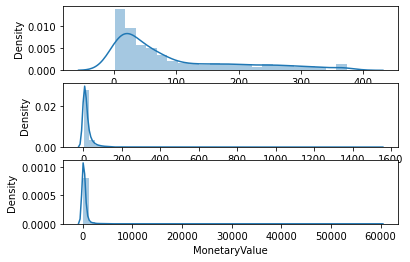

In [32]:
# Visualize RFM distributions

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(datamart_rfm['Recency'])

# Plot frequency distribution
plt.subplot(3,1,2); sns.distplot(datamart_rfm['Frequency'])

# Plot monetary value distribution
plt.subplot(3,1,3); sns.distplot(datamart_rfm['MonetaryValue'])


# Show the plot
plt.show()

## Pre-process RFM data : Normalize and standarlization

In [34]:
# Pre-process RFM data : Normalize and standarlization

# Unskew the data
datamart_log = np.log(datamart_rfm)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
datamart_normalized = scaler.transform(datamart_log)

# Create a pandas DataFrame
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)

C:\Users\taiz_\anaconda3\envs\ds\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\taiz_\anaconda3\envs\ds\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\taiz_\anaconda3\envs\ds\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

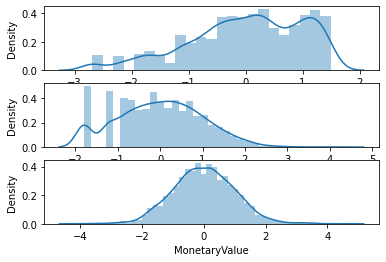

In [35]:
# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(datamart_normalized['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(datamart_normalized['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(datamart_normalized['MonetaryValue'])

# Show the plot
plt.show()

## Calculate and plot sum of squared errors

In [37]:
# define the number of clusters

# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_
cluster_labels

array([0, 0, 0, ..., 1, 0, 2])

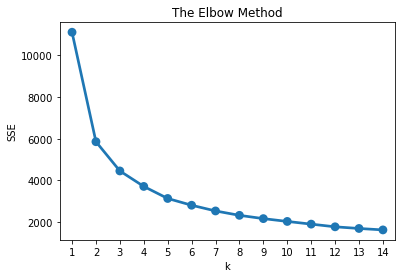

In [46]:
# Find the best k with elbow method
find_kmeans_elbow(datamart_normalized)

### Build 3-cluster solution

In [74]:
# Initialize KMeans
kmeans = KMeans(n_clusters= 3, random_state = 42) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

In [75]:
#Assign labels

# Create a DataFrame by adding a new cluster label column
datamart_rfm_k3 = datamart_normalized.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = datamart_rfm_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          -1.2       1.2           1.1   855
1           0.7      -1.0          -1.0  1225
2           0.1       0.2           0.1  1621

In [76]:
datamart_rfm_k3.head(3)

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12747,-2.195642,0.909521,1.482882,0
12748,-2.684553,3.845050,3.022433,0
12749,-1.706731,1.168000,1.331390,0


##  Snake Plot

In [77]:
#Prepare data for the snake plot
# Melt the normalized dataset and reset the index
datamart_melt = pd.melt(
                    datamart_rfm_k3.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables
                    id_vars=['CustomerID', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        
# Name the variable and value
                    var_name='Metric', value_name='Value'
                    )



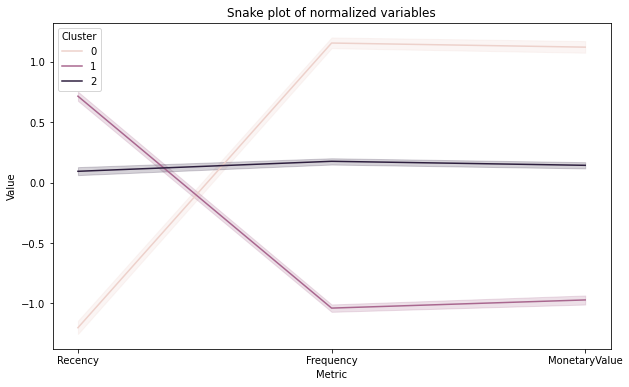

In [78]:
plt.figure(figsize=(10,6))
# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot( x='Metric', y='Value', hue='Cluster', data=datamart_melt )
plt.show()

In [79]:
#Assign cluster label for the non normalized data
data_rfm_cluster = datamart_rfm.assign(Cluster=cluster_labels)

In [80]:
# Calculate relative importance of each attribute
# Calculate average RFM values for each cluster
cluster_avg = data_rfm_cluster.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = datamart_rfm.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
relative_imp.round(2)



,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.85,1.75,1.96
1,0.82,-0.84,-0.85
2,-0.17,-0.29,-0.39


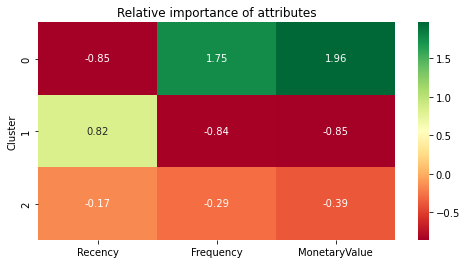

In [81]:
# Initialize a plot with a figure size of 8 by 4 inches 
plt.figure(figsize=(8, 4))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

In [82]:
cluster_avg

,Recency,Frequency,MonetaryValue
Cluster,,,
0,13.809357,52.673684,1128.054456
1,171.576327,3.116735,55.291902
2,78.353486,13.578038,232.042659


# Inference:

    It was possible to find 3 distinct groups and get some assumptions by their shopping behavior:
        - Group 0: Top! Low recency (average: 14 days), hiw frequency(53) and Monetary Value (average:$1.128)
        
        - Group 2: Middle. Average recency around 78, frequency average around 14 and Monetary values average around $ 232
        
        - Group 1: Bottom: Large recency (171 days), low frequency (onle 3 purchases) and low Monetary Value around $ 55 (all averages)
        
        

